1.Loads your saved models (VisCYPNet_CYP2C9.pth, GINE_CYP2C9.pth).

2.Computes validation probabilities for both models and aligns them by Drug_ID.

3.Sweeps α ∈ [0,1] to find the α* that maximizes ROC AUC on the validation set.

4.Evaluates the ensemble (and the two individual models) on the test set and prints the requested metrics.

In [1]:
# Cell 1 - Imports, constants, device
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch_geometric.data import DataLoader as PyGDataLoader
from sklearn.metrics import (
    roc_auc_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix,
    precision_score, recall_score, f1_score, accuracy_score
)
import matplotlib.pyplot as plt

# ---- Models & datasets 
from model_GINE import GINEModel        # GINE model class
from model_viscypnet import VisCYPNet  # image model class
from GraphDataset import GraphFolderDataset  # graph dataset wrapper
from ImageDataset import CYPImageDataset  # image dataset & transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device_str = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# Paths / constants
ISOFORM = "2C9"
# Image dataset (validation & test CSV + image dirs)
IMG_VAL_CSV = "../data/processed/2C9_val.csv"
IMG_TEST_CSV = "../data/processed/2C9_test.csv"
IMG_VAL_DIR = "../images/2C9/val/clean"
IMG_TEST_DIR = "../images/2C9/test/clean"

# Graph dataset folders
GRAPH_ROOT = "../GraphDataset"
GRAPH_VAL_FOLDER  = os.path.join(GRAPH_ROOT, ISOFORM, "val")
GRAPH_TEST_FOLDER = os.path.join(GRAPH_ROOT, ISOFORM, "test")

# Saved model weights 
VISCYP_PATH = "models/VisCYPNet_CYP2C9.pth"
GINE_PATH   = "models/GINE_CYP2C9.pth"


Device: cuda


In [2]:
# Cell 2 - Metric helpers
def safe(f, *args, **kwargs):
    try:
        return f(*args, **kwargs)
    except Exception:
        return float("nan")

def compute_classification_metrics(y_true, probs, thresh=0.5):
    y_true = np.asarray(y_true).astype(int)
    probs = np.asarray(probs).astype(float)
    preds = (probs >= thresh).astype(int)
    metrics = {
        "ROC_AUC": safe(roc_auc_score, y_true, probs),
        "ACC":     safe(accuracy_score, y_true, preds),
        "BA":      safe(balanced_accuracy_score, y_true, preds),
        "MCC":     safe(matthews_corrcoef, y_true, preds),
        "PRE":     safe(precision_score, y_true, preds, zero_division=0),
        "REC":     safe(recall_score, y_true, preds, zero_division=0),
        "F1":      safe(f1_score, y_true, preds, zero_division=0),
        "Confusion": None
    }
       # compute confusion safely
    try:
        metrics["Confusion"] = confusion_matrix(y_true, preds)
    except Exception:
        metrics["Confusion"] = None

    return metrics
    

def print_metrics_table(name, metrics):
    print(f"--- {name} ---")
    # use float() to ensure numpy scalars format
    print(f"ROC_AUC: {float(metrics['ROC_AUC']):.4f}")
    print(f"Accuracy: {float(metrics['ACC']):.4f} | BA: {float(metrics['BA']):.4f} | MCC: {float(metrics['MCC']):.4f}")
    print(f"PRE: {float(metrics['PRE']):.4f} | REC: {float(metrics['REC']):.4f} | F1: {float(metrics['F1']):.4f}")
    if metrics.get("Confusion") is not None:
        print("Confusion matrix:\n", metrics["Confusion"])
    print()


In [3]:
# Cell 3 - Build datasets and deterministic dataloaders (num_workers=0 -> safe ordering)

# load CSVs for sanity checks
img_val_df = pd.read_csv(IMG_VAL_CSV)
img_test_df = pd.read_csv(IMG_TEST_CSV)

# instantiate dataset objects (they should preserve order matching the CSV)
img_val_ds = CYPImageDataset(csv_file=IMG_VAL_CSV, image_dir=IMG_VAL_DIR)
img_test_ds = CYPImageDataset(csv_file=IMG_TEST_CSV, image_dir=IMG_TEST_DIR)

# deterministic dataloaders (no shuffling, num_workers=0 to preserve order)
img_val_loader = DataLoader(img_val_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)
img_test_loader = DataLoader(img_test_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=False)

# Graph datasets (GraphFolderDataset is assumed to expose .files list in sorted order)
assert os.path.isdir(GRAPH_VAL_FOLDER), f"Graph val folder not found: {GRAPH_VAL_FOLDER}"
assert os.path.isdir(GRAPH_TEST_FOLDER), f"Graph test folder not found: {GRAPH_TEST_FOLDER}"

graph_val_ds = GraphFolderDataset(GRAPH_VAL_FOLDER, preload=False)
graph_test_ds = GraphFolderDataset(GRAPH_TEST_FOLDER, preload=False)

graph_val_loader = PyGDataLoader(graph_val_ds, batch_size=32, shuffle=False, num_workers=0)
graph_test_loader = PyGDataLoader(graph_test_ds, batch_size=32, shuffle=False, num_workers=0)

# print some diagnostics (GraphFolderDataset expected to provide .files)
print("Image val samples:", len(img_val_ds), "Graph val files:", len(getattr(graph_val_ds, "files", [])))
print("Image test samples:", len(img_test_ds), "Graph test files:", len(getattr(graph_test_ds, "files", [])))


Image val samples: 1209 Graph val files: 1209
Image test samples: 1210 Graph test files: 1210


c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [4]:
# Cell 4 - Instantiate VisCYPNet and load weights (robust)

# Try to load CLIP (preferred), but be resilient and print helpful error if missing.
try:
    import clip
    clip_model, preprocess = clip.load("ViT-B/16", device=device_str)  # use device string for CLIP
    class Backbone(torch.nn.Module):
        def __init__(self, clip_model):
            super().__init__()
            self.visual = clip_model.visual
        def forward(self, x):
            # CLIP's visual expects preprocessed images
            return self.visual(x)
    backbone = Backbone(clip_model).to(device)
except Exception as e:
    # If clip not available or network blocked, raise a clear error so you can decide fallback.
    raise RuntimeError("Failed to load CLIP. Install 'clip' package and ensure internet access or provide a compatible backbone. Original error: " + str(e))

# instantiate model (adjust head size if you used a different one)
vis_model = VisCYPNet(
    backbone=backbone,
    backbone_name="vit_base_patch16_224",
    pretrained=False,
    head_hidden_dims=[256,64],
    head_dropout=0.2,
    device=device
).to(device)

# robust checkpoint loading
if not os.path.exists(VISCYP_PATH):
    raise FileNotFoundError(f"VisCYP checkpoint not found: {VISCYP_PATH}")

ck = torch.load(VISCYP_PATH, map_location="cpu")
if isinstance(ck, dict) and ("model" in ck or "state_dict" in ck):
    sd = ck.get("model", ck.get("state_dict", ck))
else:
    sd = ck

loaded = False
try:
    vis_model.load_state_dict(sd, strict=False)
    print("VisCYPNet: loaded state_dict (strict=False).")
    loaded = True
except Exception as e:
    # fallback: strip common prefixes
    new_sd = {}
    for k,v in sd.items():
        newk = k
        if newk.startswith("module."):
            newk = newk[len("module."):]
        if newk.startswith("backbone."):
            # careful: only strip a single prefix
            newk = newk[len("backbone."):]
        new_sd[newk] = v
    try:
        vis_model.load_state_dict(new_sd, strict=False)
        print("VisCYPNet: loaded after key-stripping (strict=False).")
        loaded = True
    except Exception as e2:
        print("VisCYPNet: still failed to load checkpoint. Please inspect saved file format.")
        raise

vis_model.eval()


VisCYPNet: loaded state_dict (strict=False).


C:\Users\Afra\AppData\Local\Temp\ipykernel_25744\1545960872.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ck = torch.load(VISCYP_PATH, map_location="cpu")


VisCYPNet(
  (backbone): Backbone(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
      (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
            )
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=768, out_features=3072, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=3072, out_features=768, bias=True)
            )
            (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuant

In [5]:
# Cell 5 - Inspect one graph to obtain in_node_feats and in_edge_feats, then instantiate GINE and load weights

# pick first file and inspect
sample_graph_path = graph_val_ds.files[0]
sample_data = torch.load(sample_graph_path)
in_node_feats = sample_data.x.shape[1]
in_edge_feats = sample_data.edge_attr.shape[1] if getattr(sample_data, "edge_attr", None) is not None else None
print("Sample in_node_feats:", in_node_feats, "in_edge_feats:", in_edge_feats)

# model params must match training config -- change keys if your GINE used different names
gine_model_params = {
    "model_embedding_size": 128,
    "model_layers": 4,
    "model_dropout_rate": 0.2,
    "model_dense_neurons": 256,
    "use_bn": True
}

gine = GINEModel(in_node_feats, in_edge_feats, model_params=gine_model_params).to(device)

# Load checkpoint robustly (support saved state_dict or {"model":...})
ck2 = torch.load(GINE_PATH, map_location="cpu")
sd2 = ck2.get("model", ck2) if isinstance(ck2, dict) else ck2
try:
    gine.load_state_dict(sd2, strict=False)
    print("GINE: loaded weights (strict=False).")
except Exception as e:
    # attempt prefix cleanup
    new_sd2 = {}
    for k,v in sd2.items():
        newk = k[len("module."):] if k.startswith("module.") else k
        new_sd2[newk] = v
    gine.load_state_dict(new_sd2, strict=False)
    print("GINE: loaded after key-stripping.")

gine.eval()


Sample in_node_feats: 94 in_edge_feats: 42
GINE: loaded weights (strict=False).


C:\Users\Afra\AppData\Local\Temp\ipykernel_25744\3461208096.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_data = torch.load(sample_graph_path)
C:\Users\Afra\App

GINEModel(
  (node_encoder): Linear(in_features=94, out_features=128, bias=True)
  (edge_encoder): Linear(in_features=42, out_features=128, bias=True)
  (convs): ModuleList(
    (0-3): 4 x GINEConv(nn=Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
    ))
  )
  (bns): ModuleList(
    (0-3): 4 x BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (head): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [6]:
# Cell 6 - Robust prediction utilities (explicit device+dtype alignment)
import os
import numpy as np
import torch
from PIL import Image as PILImage
from torch.utils.data import DataLoader
from torch_geometric.data import DataLoader as PyGDataLoader

# Helper to parse drug id from file name like "12345_1.pt" or "12345_0.pt"
def drugid_from_filename(fname):
    base = os.path.basename(fname)
    name = os.path.splitext(base)[0]
    return name.split('_')[0]

# -----------------------
# IMAGE: helper converters
# -----------------------
def sample_to_img_label(sample):
    """
    Convert a single dataset sample into (img_raw, label_raw).
    Sample formats supported:
      - tuple/list: (img, label, ...)
      - dict: {'image':..., 'img':..., 'input':...} and {'label'/'y'/'target'}
    """
    if isinstance(sample, (list, tuple)):
        if len(sample) >= 2:
            return sample[0], sample[1]
        raise ValueError("Unexpected sample tuple length < 2.")
    if isinstance(sample, dict):
        img_keys = ['image', 'img', 'input', 'x', 'img_raw']
        lab_keys = ['label', 'y', 'target']
        img = None; lab = None
        for k in img_keys:
            if k in sample:
                img = sample[k]; break
        for k in lab_keys:
            if k in sample:
                lab = sample[k]; break
        if img is not None and lab is not None:
            return img, lab
        vals = list(sample.values())
        if len(vals) >= 2:
            return vals[0], vals[1]
        raise ValueError("Dict sample lacks image/label keys.")
    raise ValueError(f"Unsupported sample type: {type(sample)}")

def imgs_list_to_tensor(imgs_list, preprocess_fn):

    """
    Convert a list of image elements into a batched torch.Tensor (B,C,H,W).
    Supported element types:
      - torch.Tensor (assumed C,H,W or 1,C,H,W)
      - PIL.Image.Image
      - numpy.ndarray (H,W,C) or (C,H,W)
      - str filepath -> will be opened if exists
    preprocess_fn: function that converts a PIL.Image -> torch.Tensor (C,H,W)
                   e.g. clip.preprocess or torchvision transforms
    """
    processed = []
    for im in imgs_list:
        if isinstance(im, torch.Tensor):
            t = im
            if t.ndim == 4 and t.shape[0] == 1:
                t = t.squeeze(0)
            if t.ndim != 3:
                raise ValueError(f"Unexpected tensor image shape: {t.shape}")
            processed.append(t)
            continue
        if isinstance(im, PILImage.Image) or isinstance(im, PILImage):
            processed.append(preprocess_fn(im))
            continue
        if isinstance(im, np.ndarray):
            if im.ndim == 3 and (im.shape[2] == 3 or im.shape[2] == 1):
                pil = PILImage.fromarray(im.astype('uint8'))
                processed.append(preprocess_fn(pil))
                continue
            elif im.ndim == 2:
                pil = PILImage.fromarray(im.astype('uint8')).convert('RGB')
                processed.append(preprocess_fn(pil))
                continue
            else:
                raise ValueError(f"Unsupported numpy image shape: {im.shape}")
        if isinstance(im, str):
            if os.path.exists(im):
                pil = PILImage.open(im).convert('RGB')
                processed.append(preprocess_fn(pil))
                continue
            else:
                raise ValueError(f"Image path not found: {im}")
        raise ValueError(f"Unsupported image element type in batch: {type(im)}")

    processed = [p if isinstance(p, torch.Tensor) else torch.tensor(p) for p in processed]
    processed = [p.float() for p in processed]
    return torch.stack(processed, dim=0)

def normalize_label(lbl):
    if isinstance(lbl, torch.Tensor):
        return int(lbl.cpu().numpy().astype(int).flatten()[0])
    else:
        return int(np.asarray(lbl).astype(int).flatten()[0])

def predict_probs_vis(model, dataset, df_csv, device, batch_size=64, preprocess_fn=None):
    """
    Predict probabilities for images.
    - dataset: CYPImageDataset instance (may return PIL images)
    - df_csv: path or DataFrame used to construct dataset (must have 'Drug_ID' and 'Y' columns)
    - preprocess_fn: function PIL -> tensor (e.g. clip.preprocess). If None, dataset must already return tensors.
    Returns: dict {drug_id_str: (prob, label)}
    """
    if preprocess_fn is None:
        def identity(x): return x
        preprocess_fn = identity

    if isinstance(df_csv, str):
        df = pd.read_csv(df_csv)
    else:
        df = df_csv.reset_index(drop=True)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0,
                        pin_memory=False, collate_fn=lambda b: b)

    model.eval()
    probs_list = []
    labels_list = []

    # determine model dtype + device (use first parameter)
    try:
        model_param = next(model.parameters())
        model_dtype = model_param.dtype
        model_device = model_param.device
    except StopIteration:
        model_dtype = torch.float32
        model_device = torch.device(device)

    with torch.no_grad():
        for batch in loader:
            imgs_raw = []
            lbls_raw = []
            for sample in batch:
                img_r, lbl_r = sample_to_img_label(sample)
                imgs_raw.append(img_r)
                lbls_raw.append(normalize_label(lbl_r))

            imgs_tensor = imgs_list_to_tensor(imgs_raw, preprocess_fn)  # (B,C,H,W) in float32
            # move to the same device AND dtype as model parameters in a single operation:
            imgs_tensor = imgs_tensor.to(device=model_device, dtype=model_dtype)

            # Debug: uncomment to check types if problems persist
            # print("DEBUG: imgs_tensor device/dtype:", imgs_tensor.device, imgs_tensor.dtype)
            # print("DEBUG: model device/dtype:", model_device, model_dtype)

            logits = model(imgs_tensor)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            probs_list.extend(probs.tolist())
            labels_list.extend(lbls_raw)

    if len(probs_list) != len(df):
        raise ValueError(f"Number of image predictions ({len(probs_list)}) != number of rows in CSV ({len(df)}). "
                         "Check dataset ordering and CSV.")

    out = {}
    for i, drug_id in enumerate(df["Drug_ID"].astype(str).values):
        out[drug_id] = (float(probs_list[i]), int(df.loc[i, "Y"]))
    return out

# -----------------------
# GRAPH: prediction util
# -----------------------
def predict_probs_gine(model, graph_dataset, device, batch_size=32):
    
    """
    Predict probabilities for graphs using torch_geometric DataLoader.
    graph_dataset must expose .files (list of file paths or filenames) in the same order it yields graphs.
    Returns: dict {drug_id_str: (prob, label)}
    """
    loader = PyGDataLoader(graph_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    model.eval()
    out = {}

    file_list = getattr(graph_dataset, "files", None)
    if file_list is None:
        raise RuntimeError("graph_dataset must expose a .files attribute with file paths or names in the same order.")

    f_idx = 0
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            edge_attr = batch.edge_attr if hasattr(batch, "edge_attr") else None
            logits = model(batch.x.float(), batch.edge_index, edge_attr, batch.batch)
            probs = torch.sigmoid(logits).cpu().numpy().flatten()
            bsize = probs.shape[0]
            for j in range(bsize):
                filepath = file_list[f_idx + j]
                did = drugid_from_filename(filepath)
                y_val = batch.y[j].cpu().numpy()
                try:
                    label = int(np.asarray(y_val).astype(int).flatten()[0])
                except Exception:
                    label = int(np.asarray(y_val).astype(int))
                out[did] = (float(probs[j]), int(label))
            f_idx += bsize
    return out



In [7]:
# Quick fix: force the visual model to float32 
vis_model = vis_model.float().to(device)   # convert model weights to float32 and move to device
gine = gine.float().to(device)             # also convert GINE to float32 (if you will predict with it)
print("vis_model dtype/device:", next(vis_model.parameters()).dtype, next(vis_model.parameters()).device)


vis_model dtype/device: torch.float32 cuda:0


In [8]:
# Cell 7 - Get val probs and align by Drug_ID, then sweep alpha to maximize ROC AUC

print("Predicting VisCYPNet on validation images...")
vis_val_map = predict_probs_vis(vis_model, img_val_ds, img_val_df, device,
                                batch_size=64, preprocess_fn=preprocess)
print("Predicting GINE on validation graphs...")
gine_val_map = predict_probs_gine(gine, graph_val_ds, device, batch_size=32)

Predicting VisCYPNet on validation images...
Predicting GINE on validation graphs...


c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommen

In [9]:
# --- Replace intersection/alignment block with this normalized-version

def normalize_drugid_key(k):
    """
    Turn k (float, int, or str) into canonical string ID.
    - floats that are integers (6604782.0) -> '6604782'
    - strings like '6604782.0' -> '6604782'
    - other strings are stripped and returned
    """
    if isinstance(k, float):
        if np.isfinite(k) and float(k).is_integer():
            return str(int(k))
        else:
            return str(k)
    if isinstance(k, (int, np.integer)):
        return str(int(k))
    if isinstance(k, str):
        s = k.strip()
        # remove trailing .0 if present (common from CSV->float->str)
        if s.endswith('.0'):
            try:
                return str(int(float(s)))
            except Exception:
                return s
        return s
    # fallback
    return str(k)

# normalize both maps
vis_val_map_norm = {normalize_drugid_key(k): v for k, v in vis_val_map.items()}
gine_val_map_norm = {normalize_drugid_key(k): v for k, v in gine_val_map.items()}

# debug: show a few examples of original -> normalized 
print("Example keys (vis original -> normalized):", list(zip(list(vis_val_map.keys())[:5], list(vis_val_map_norm.keys())[:5])))
print("Example keys (gine original -> normalized):", list(zip(list(gine_val_map.keys())[:5], list(gine_val_map_norm.keys())[:5])))

# intersection
vis_keys = set(vis_val_map_norm.keys())
gine_keys = set(gine_val_map_norm.keys())
common_keys = sorted(list(vis_keys & gine_keys))
print("Validation - Vis keys:", len(vis_keys), "GINE keys:", len(gine_keys), "Intersection:", len(common_keys))

if len(common_keys) == 0:
    # helpful diagnostics if still empty
    print("Sample vis keys (first 20):", list(vis_keys)[:20])
    print("Sample gine keys (first 20):", list(gine_keys)[:20])
    raise RuntimeError("No overlapping Drug_IDs between image val set and graph val set. Ensure file naming and CSVs match.")

# build aligned arrays using normalized maps
y_val = np.array([vis_val_map_norm[k][1] for k in common_keys])
p_vis_val = np.array([vis_val_map_norm[k][0] for k in common_keys])
p_gine_val = np.array([gine_val_map_norm[k][0] for k in common_keys])


Example keys (vis original -> normalized): [('5348064.0', '5348064'), ('5728807.0', '5728807'), ('651959.0', '651959'), ('135403641.0', '135403641'), ('5334183.0', '5334183')]
Example keys (gine original -> normalized): [('1008028', '1008028'), ('1008368', '1008368'), ('1015792', '1015792'), ('1016499', '1016499'), ('1023', '1023')]
Validation - Vis keys: 1209 GINE keys: 1209 Intersection: 1209


Best alpha on validation: alpha* = 0.860 with ROC AUC = 0.8916195043964829


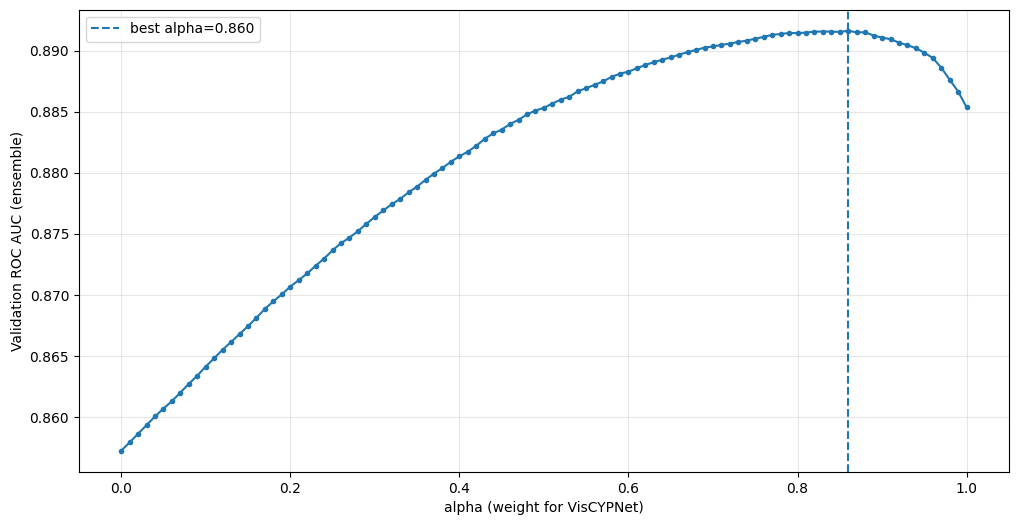

In [10]:

# sweep alpha safely (handle NaNs)
alphas = np.linspace(0.0, 1.0, 101)
best_alpha = None
best_auc = -np.inf
auc_list = []
for a in alphas:
    p_ens = a * p_vis_val + (1.0 - a) * p_gine_val
    try:
        auc = float(roc_auc_score(y_val, p_ens))
    except Exception:
        auc = float("nan")
    auc_list.append(auc)
    # update only if auc is a real number
    if not np.isnan(auc) and auc > best_auc:
        best_auc = auc
        best_alpha = float(a)

if best_alpha is None:
    print("Warning: no valid AUC computed during sweep (likely single-class labels). Picking alpha=0.5 by default.")
    best_alpha = 0.5
    best_auc = float("nan")

print(f"Best alpha on validation: alpha* = {best_alpha:.3f} with ROC AUC = {best_auc if not np.isnan(best_auc) else 'nan'}")

# plot
plt.figure(figsize=(12,6))
plt.plot(alphas, auc_list, marker=".")
if best_alpha is not None:
    plt.axvline(best_alpha, linestyle="--", label=f"best alpha={best_alpha:.3f}")
plt.xlabel("alpha (weight for VisCYPNet)")
plt.ylabel("Validation ROC AUC (ensemble)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


In [11]:
# Cell 8 - Predict on test sets, align by Drug_ID, evaluate Vis, GINE and ensemble with best_alpha

print("Predicting VisCYPNet on test images...")
vis_test_map = predict_probs_vis(vis_model, img_test_ds, img_test_df, device,
                                batch_size=64, preprocess_fn=preprocess)
print("Predicting GINE on test graphs...")
gine_test_map = predict_probs_gine(gine, graph_test_ds, device, batch_size=32)

Predicting VisCYPNet on test images...
Predicting GINE on test graphs...


c:\Users\Afra\AppData\Local\Programs\Python\Python39\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
e:\پروژه ها\پردازش تصویر دکتر برزگر\predicting cyp450 with image\main code\VisCYPMoleCLIP-GINE\src\GraphDataset.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommen

In [12]:
# --- Normalized alignment & evaluation for TEST set (drop-in replacement) ----

def normalize_drugid_key(k):
    """
    Turn k (float, int, or str) into canonical string ID.
    - floats that are integers (6604782.0) -> '6604782'
    - strings like '6604782.0' -> '6604782'
    - other strings are stripped and returned
    """
    if isinstance(k, float):
        if np.isfinite(k) and float(k).is_integer():
            return str(int(k))
        else:
            return str(k)
    if isinstance(k, (int, np.integer)):
        return str(int(k))
    if isinstance(k, str):
        s = k.strip()
        if s.endswith('.0'):
            try:
                return str(int(float(s)))
            except Exception:
                return s
        return s
    return str(k)

# Normalize test maps
vis_test_map_norm  = {normalize_drugid_key(k): v for k, v in vis_test_map.items()}
gine_test_map_norm = {normalize_drugid_key(k): v for k, v in gine_test_map.items()}



In [13]:
# Debug examples (optional)
print("Example keys (vis original -> normalized):", list(zip(list(vis_test_map.keys())[:5], list(vis_test_map_norm.keys())[:5])))
print("Example keys (gine original -> normalized):", list(zip(list(gine_test_map.keys())[:5], list(gine_test_map_norm.keys())[:5])))


Example keys (vis original -> normalized): [('1082582.0', '1082582'), ('2949967.0', '2949967'), ('3996604.0', '3996604'), ('5172334.0', '5172334'), ('3246641.0', '3246641')]
Example keys (gine original -> normalized): [('1001112', '1001112'), ('1001133', '1001133'), ('100426', '100426'), ('100603', '100603'), ('1006913', '1006913')]


In [14]:
# Intersection using normalized keys
common_test_keys = sorted(list(set(vis_test_map_norm.keys()) & set(gine_test_map_norm.keys())))
print("Test - Vis keys:", len(vis_test_map_norm), "GINE keys:", len(gine_test_map_norm), "Intersection:", len(common_test_keys))

if len(common_test_keys) == 0:
    print("Sample vis_test keys (first 20):", list(vis_test_map_norm.keys())[:20])
    print("Sample gine_test keys (first 20):", list(gine_test_map_norm.keys())[:20])
    raise RuntimeError("No overlap between image test and graph test keys after normalization. Check IDs/filenames/CSV.")

Test - Vis keys: 1210 GINE keys: 1210 Intersection: 1210


In [15]:
# Build aligned arrays from normalized maps
y_test = np.array([vis_test_map_norm[k][1] for k in common_test_keys])
p_vis_test = np.array([vis_test_map_norm[k][0] for k in common_test_keys])
p_gine_test = np.array([gine_test_map_norm[k][0] for k in common_test_keys])
p_ens_test = best_alpha * p_vis_test + (1.0 - best_alpha) * p_gine_test

# Compute metrics
m_vis  = compute_classification_metrics(y_test, p_vis_test)
m_gine = compute_classification_metrics(y_test, p_gine_test)
m_ens  = compute_classification_metrics(y_test, p_ens_test)

print_metrics_table("VisCYPNet (test)", m_vis)
print_metrics_table("GINE (test)", m_gine)
print_metrics_table(f"Ensemble (alpha={best_alpha:.3f}) (test)", m_ens)

# compact comparison table
df_summary = pd.DataFrame({
    "Metric": ["ROC_AUC","BA","MCC","PRE","REC","F1","ACC"],
    "VisCYPNet": [m_vis["ROC_AUC"], m_vis["BA"], m_vis["MCC"], m_vis["PRE"], m_vis["REC"], m_vis["F1"], m_vis["ACC"]],
    "GINE":      [m_gine["ROC_AUC"], m_gine["BA"], m_gine["MCC"], m_gine["PRE"], m_gine["REC"], m_gine["F1"], m_gine["ACC"]],
    "Ensemble":  [m_ens["ROC_AUC"], m_ens["BA"], m_ens["MCC"], m_ens["PRE"], m_ens["REC"], m_ens["F1"], m_ens["ACC"]],
})
print(df_summary.to_string(index=False, float_format='%.4f'))


--- VisCYPNet (test) ---
ROC_AUC: 0.8809
Accuracy: 0.8157 | BA: 0.7712 | MCC: 0.5679
PRE: 0.7560 | REC: 0.6430 | F1: 0.6949
Confusion matrix:
 [[733  82]
 [141 254]]

--- GINE (test) ---
ROC_AUC: 0.8275
Accuracy: 0.6777 | BA: 0.7379 | MCC: 0.4538
PRE: 0.5035 | REC: 0.9114 | F1: 0.6486
Confusion matrix:
 [[460 355]
 [ 35 360]]

--- Ensemble (alpha=0.860) (test) ---
ROC_AUC: 0.8882
Accuracy: 0.8215 | BA: 0.7892 | MCC: 0.5882
PRE: 0.7412 | REC: 0.6962 | F1: 0.7180
Confusion matrix:
 [[719  96]
 [120 275]]

 Metric  VisCYPNet   GINE  Ensemble
ROC_AUC     0.8809 0.8275    0.8882
     BA     0.7712 0.7379    0.7892
    MCC     0.5679 0.4538    0.5882
    PRE     0.7560 0.5035    0.7412
    REC     0.6430 0.9114    0.6962
     F1     0.6949 0.6486    0.7180
    ACC     0.8157 0.6777    0.8215
